In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset
from transformers import  RobertaConfig, RobertaModel, RobertaTokenizer
import argparse
import json
import os
from model2 import Model
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset
import random
import multiprocessing
from tqdm import tqdm, trange
import numpy as np
import javalang
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
np.random.seed(0)
import seaborn as sns
import collections
import pickle
import sklearn
from matplotlib import cm
from sklearn import manifold

sns.set_style("darkgrid")
BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"
YELLOW = "#f1c40f"
GRAY = "#95a5a6"
BROWN = "#8e44ad"
CYAN = "#8e44ad"

In [2]:
class TextDataset(Dataset):
    def __init__(self, tokenizer, sample_size=1000, file_path='train', block_size=512,pool=None):
        postfix=file_path.split('/')[-1].split('.txt')[0]
        self.examples = []
        index_filename=file_path
        print("Creating features from index file at %s ", index_filename)
        url_to_code={}
        with open('/'.join(index_filename.split('/')[:-1])+'/data.jsonl') as f:
            for line in f:
                line=line.strip()
                js=json.loads(line)
                url_to_code[js['idx']]=js['func']
        data=[]
        cache={}
        f=open(index_filename)
        with open(index_filename) as f:
            for line in f:
                line=line.strip()
                url1,url2,label=line.split('\t')
                if url1 not in url_to_code or url2 not in url_to_code:
                    continue
                if label=='0':
                    label=0
                else:
                    label=1
                data.append((url1,url2,label,tokenizer,cache,url_to_code))
        data=data[:sample_size]

        self.examples=pool.map(get_example,tqdm(data,total=len(data)))
    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item].input_ids),torch.tensor(self.examples[item].label)


In [3]:
def get_example(item):
    url1,url2,label,tokenizer,cache,url_to_code=item
    if url1 in cache:
        code1=cache[url1].copy()
    else:
        try:
            code=' '.join(url_to_code[url1].split())
        except:
            code=""
        code1=tokenizer.tokenize(code)
    if url2 in cache:
        code2=cache[url2].copy()
    else:
        try:
            code=' '.join(url_to_code[url2].split())
        except:
            code=""
        code2=tokenizer.tokenize(code)
        
    return convert_examples_to_features(code1,code2,label,url1,url2,tokenizer,block_size, cache)

In [4]:
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 input_tokens,
                 input_ids,
                 label,
                 url1,
                 url2):
        self.input_tokens = input_tokens
        self.input_ids = input_ids
        self.label=label
        self.url1=url1
        self.url2=url2

In [5]:
def load_and_cache_examples(tokenizer, 
                            test_data_file,
                            block_size, 
                            sample_size=1000,
                            evaluate=False,
                            test=False,
                            pool=None):
    dataset = TextDataset(tokenizer, 
                          file_path=test_data_file,
                          sample_size=sample_size,
                          block_size=block_size,
                          pool=pool)
    return dataset

In [6]:
def convert_examples_to_features(code1_tokens,code2_tokens,label,url1,url2,tokenizer,block_size,cache):
    code1_tokens=code1_tokens[:block_size-2]
    code1_tokens =[tokenizer.cls_token]+code1_tokens+[tokenizer.sep_token]
    code2_tokens=code2_tokens[:block_size-2]
    code2_tokens =[tokenizer.cls_token]+code2_tokens+[tokenizer.sep_token]  
    
    code1_ids=tokenizer.convert_tokens_to_ids(code1_tokens)
    padding_length = block_size - len(code1_ids)
    code1_ids+=[tokenizer.pad_token_id]*padding_length
    
    code2_ids=tokenizer.convert_tokens_to_ids(code2_tokens)
    padding_length = block_size - len(code2_ids)
    code2_ids+=[tokenizer.pad_token_id]*padding_length
    
    source_tokens=code1_tokens+code2_tokens
    source_ids=code1_ids+code2_ids
    return InputFeatures(source_tokens,source_ids,label,url1,url2)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = RobertaConfig.from_pretrained('microsoft/codebert-base')

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

model = RobertaModel.from_pretrained('microsoft/codebert-base',
                                    output_attentions=True, 
                                    output_hidden_states=True)

model=Model(model,config,tokenizer)

checkpoint_prefix = "saved_models/checkpoint-best-f1/model.bin"

model.load_state_dict(torch.load(checkpoint_prefix))

model = model.to(device)

In [8]:
# test_data_file = "../dataset/valid.txt"
# block_size = 400
# cpu_cont = 16
# pool = multiprocessing.Pool(cpu_cont)
# eval_dataset = load_and_cache_examples(tokenizer,
#                                        test_data_file,
#                                        block_size,
#                                        evaluate=True,pool=pool)

In [9]:
file_path = "../dataset/valid.txt"
postfix=file_path.split('/')[-1].split('.txt')[0]
index_filename=file_path
url_to_code={}
with open('/'.join(index_filename.split('/')[:-1])+'/data.jsonl') as f:
    for line in f:
        line=line.strip()
        js=json.loads(line)
        url_to_code[js['idx']]=js['func']
data=[]
cache={}
f=open(index_filename)
with open(index_filename) as f:
    # lines = 1000
    added_lines = 0
    for line in f:
        # if added_lines >= lines:
        #     break
        line=line.strip()
        url1,url2,label=line.split('\t')
        if url1 not in url_to_code or url2 not in url_to_code:
            continue
        if label=='0':
            label=0
        else:
            label=1
        data.append((url1,url2,label,' '.join(url_to_code[url1].split()), ' '.join(url_to_code[url2].split())))
        added_lines += 1

In [10]:
len(data)

415416

In [11]:
data[100]

('6814854',
 '3298292',
 0,
 'public static boolean encodeFileToFile(String infile, String outfile) { boolean success = false; java.io.InputStream in = null; java.io.OutputStream out = null; try { in = new Base64.InputStream(new java.io.BufferedInputStream(new java.io.FileInputStream(infile)), Base64.ENCODE); out = new java.io.BufferedOutputStream(new java.io.FileOutputStream(outfile)); byte[] buffer = new byte[65536]; int read = -1; while ((read = in.read(buffer)) >= 0) { out.write(buffer, 0, read); } success = true; } catch (java.io.IOException exc) { exc.printStackTrace(); } finally { try { in.close(); } catch (Exception exc) { } try { out.close(); } catch (Exception exc) { } } return success; }',
 'public static String rename_tag(String sessionid, String originalTag, String newTagName) { String jsonstring = ""; try { Log.d("current running function name:", "rename_tag"); HttpClient httpclient = new DefaultHttpClient(); HttpPost httppost = new HttpPost("https://mt0-app.cloud.cm/rpc/

### Get Attention 

In [22]:
code_sample = data[0]
types_1, rewrote_code_1 = get_syntax_types_for_code(code_sample[3])
types_2, rewrote_code_2 = get_syntax_types_for_code(code_sample[4])

In [23]:
block_size = 400
tokenized_ids_1 = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(rewrote_code_1))
tokenized_ids_2 = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(rewrote_code_2))
if len(tokenized_ids_2) > 400:
    tokenized_ids_2 = tokenized_ids_2[:399] + [tokenizer.sep_token_id]

if len(tokenized_ids_1) > 400:
    tokenized_ids_1 = tokenized_ids_1[:399] + [tokenizer.sep_token_id]

padding_length = block_size - len(tokenized_ids_1)
tokenized_ids_1+=[tokenizer.pad_token_id]*padding_length
padding_length = block_size - len(tokenized_ids_2)
tokenized_ids_2+=[tokenizer.pad_token_id]*padding_length

source_ids = tokenized_ids_1 + tokenized_ids_2
labels = code_sample[2]
source_ids = torch.tensor(source_ids).unsqueeze(0).to(device)
labels = torch.tensor(labels).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(block_size,source_ids,labels)

In [25]:
def create_pos_attn_patterns(attentions):
    '''
    Creates attention patterns related to positional encoding for attention initialization
    one_to_one - pays attention to the corresponding token
    next_token - pays attention to the next token
    prev_token - pays attention to the previous token
    cls_token  - pays attention to the first index ([CLS])
    '''

    one_to_one = torch.eye(attentions[0].shape[-1])
    next_token = torch.cat((torch.cat((torch.zeros(attentions[0].shape[-1]-1, 1), torch.eye(attentions[0].shape[-1]-1)), dim=1),\
        torch.zeros(1, attentions[0].shape[-1])), dim=0)
    prev_token = torch.cat((torch.zeros(1, attentions[0].shape[-1]), \
        torch.cat((torch.eye(attentions[0].shape[-1]-1), torch.zeros(attentions[0].shape[-1]-1, 1)), dim=1)), dim=0)
    cls_token = torch.zeros(attentions[0].shape[-1], attentions[0].shape[-1])
    cls_token[:,0] = 1.

    return [one_to_one, next_token, prev_token, cls_token]   

In [45]:
def compute_ag_loss(inputs, attentions, device, attn_head_types='0,1,1,4'):
        '''
        Adds a random loss based on attention values
        To test gradients
        outputs[-1] contains the attention values (tuple of size num_layers)
        and each elements is of the shape
        [batch_size X num_heads X max_sequence_len X max_sequence_len]
        '''
        # Get the attention head types
        attn_head_types = [int(i) for i in attn_head_types.split(',')]

        # The number attention heads of each type. one-to-one, next, previous, first
        numbers = attn_head_types
        print('numbers:', numbers)
        cum_sum = np.cumsum(numbers)
        print('cum_sum:', cum_sum)
        # Matrices containing the attention patterns
        targets = create_pos_attn_patterns(attentions)

        # Loss for positional attention patterns
        expanded_targets = []
        loss = torch.nn.MSELoss()
        total_loss = 0.        

        # Change the tensor's dimension
        for (num, target) in zip(numbers, targets):
            print('num:', num)
            print('target shape', target.shape)
            print('target', target)
            if num == 0:
                expanded_targets.append(None)
            else:
                # Add dimensions so that the tensor can be repeated
                target = torch.unsqueeze(target, 0)
                target = torch.unsqueeze(target, 0)

                # Change the target tensor's dimension so that it matches batch_size X num_heads[chosen]
                target = target.repeat(attentions[0].shape[0], num, 1, 1)
                target = target.to(device)
                expanded_targets.append(target)

        # Go over all the layers
        for i in range(len(attentions)):
            for j in range(len(numbers)):
                if expanded_targets[j] is not None:
                    if j == 0:
                        total_loss += loss(expanded_targets[j], attentions[i][:,0:cum_sum[j]])
                    else:
                        total_loss += loss(expanded_targets[j], attentions[i][:,cum_sum[j-1]:cum_sum[j]])
  
        return total_loss

In [47]:
def linear_schedule_for_scale(num_stagnant_steps=2000):
    """
    Linear schedule for scale, the relative weight assigned
    to ag_loss
    """
    tot = t_total
    cur = global_step
    if cur < num_stagnant_steps:
        return 1.0
    else:
        return max(0.0, float(tot - cur) / float(max(1, tot - num_stagnant_steps)))

In [48]:
output[0]

tensor(0.0045, device='cuda:0')

In [46]:
scale = 1
mlm_loss = output[0]
ag_loss = compute_ag_loss(source_ids, output[2].attentions, device, attn_head_types='0,1,1,4')

loss = mlm_loss + ag_loss * scale * linear_schedule_for_scale()

numbers: [0, 1, 1, 4]
cum_sum: [0 1 2 6]
num: 0
target shape torch.Size([400, 400])
target tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
num: 1
target shape torch.Size([400, 400])
target tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
num: 1
target shape torch.Size([400, 400])
target tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])
num: 4
target shape torch.Size([400, 400])
targ

In [40]:
ag_loss

tensor(0.0971, device='cuda:0')

In [12]:
def get_syntax_types_for_code(code_snippet):
  types = ["[CLS]"]
  code = ["<s>"]
  tree = list(javalang.tokenizer.tokenize(code_snippet))
  
  for i in tree:
    j = str(i)
    j = j.split(" ")
    if j[1] == '"MASK"':
      types.append('[MASK]')
      code.append('<mask>')
    else:
      types.append(j[0].lower())
      code.append(j[1][1:-1])
    
  types.append("[SEP]")
  code.append("</s>")
  return np.array(types), ' '.join(code)

In [12]:
def get_start_end_of_token_when_tokenized(code, types, tokenizer):
  reindexed_types = []
  start = 0
  end = 0
  for index, each_token in enumerate(code.split(" ")):
    tokenized_list = tokenizer.tokenize(each_token)
    for i in range(len(tokenized_list)):
      end += 1
    reindexed_types.append((start, end-1))
    start = end
  return reindexed_types

In [13]:
def getSyntaxAttentionScore(model, data, tokenizer, syntaxList, model_type='finetuned'):
    block_size = 400
    all_instances = []
    number = 0
    for code_sample in tqdm(data):
        Instantce_Result = {}
        for syntaxType in syntaxList:
            Instantce_Result[syntaxType+model_type] = []

        types_1, rewrote_code_1 = get_syntax_types_for_code(code_sample[3])
        types_2, rewrote_code_2 = get_syntax_types_for_code(code_sample[4])
        
        tokenized_ids_1 = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(rewrote_code_1))
        tokenized_ids_2 = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(rewrote_code_2))

        if len(tokenized_ids_2) > 400:
            tokenized_ids_2 = tokenized_ids_2[:399] + [tokenizer.sep_token_id]

        if len(tokenized_ids_1) > 400:
            tokenized_ids_1 = tokenized_ids_1[:399] + [tokenizer.sep_token_id]
        
        padding_length = block_size - len(tokenized_ids_1)
        tokenized_ids_1+=[tokenizer.pad_token_id]*padding_length
        padding_length = block_size - len(tokenized_ids_2)
        tokenized_ids_2+=[tokenizer.pad_token_id]*padding_length

        source_ids = tokenized_ids_1 + tokenized_ids_2
        labels = code_sample[2]
        source_ids = torch.tensor(source_ids).unsqueeze(0).to(device)
        labels = torch.tensor(labels).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(block_size,source_ids,labels)

        _attention = output[2].attentions
        start_end = get_start_end_of_token_when_tokenized(rewrote_code_1, types_1, tokenizer)
        
        for syntaxType in syntaxList:
            attention_weights = [[[] for col in range(12)] for row in range(12)]
            for layer in range(12):
                for head in range(12):
                    for each_sep_index in np.where(types_1==syntaxType)[0]:
                        start_index, end_index = start_end[each_sep_index]
                        interim_value = _attention[layer][0][head][:, start_index:end_index+1].mean().cpu().detach().numpy()
                        if np.isnan(interim_value):
                            pass
                        else: 
                            attention_weights[layer][head].append(interim_value)     
            if np.array(attention_weights).shape[2] != 0:
                Instantce_Result[syntaxType+model_type].append(np.array(attention_weights))
                            
        all_instances.append(Instantce_Result)
        
    return all_instances

In [14]:
syntax_list = ['annotation', 'basictype', 'boolean', 
          'decimalinteger', 'identifier', 'keyword',
          'modifier', 'operator', 'separator', 'null',
          'string', 'decimalfloatingpoint']

In [15]:
syntax_attention_weights = getSyntaxAttentionScore(model, data[:10], tokenizer, syntax_list, model_type='finetuned')

100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


In [17]:
avg_attns = {}
for syntaxType in syntax_list:
    temp = []
    for instance in syntax_attention_weights:
        a = np.array(instance[syntaxType+'finetuned'])
        if a.shape[0] != 0:
            a = a.squeeze(0)
            a = a.mean(axis=2)
            temp.append(a)
    if len(temp) != 0:
        temp = np.array(temp)
        temp = temp.reshape(temp.shape[1], temp.shape[2], temp.shape[0])
        avg_temp = temp.mean(axis=2)
        avg_attns[syntaxType] = avg_temp

In [18]:
avg_attns.keys()

dict_keys(['basictype', 'boolean', 'decimalinteger', 'identifier', 'keyword', 'modifier', 'operator', 'separator', 'null', 'string'])

In [19]:
def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(12):
    for head in range(12):
      ys.append(head_data[layer][head])
      xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
  return xs, ys, avgs

def add_line(key, ax, color, label, plot_avgs=True):
  xs, ys, avgs = get_data_points(avg_attns[key])
  ax.scatter(xs, ys, s=12, label=label, color=color)
  if plot_avgs:
    ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
  ax.legend(loc="best")
  ax.set_xlabel("Layer")
  ax.set_ylabel("Avg. Attention")

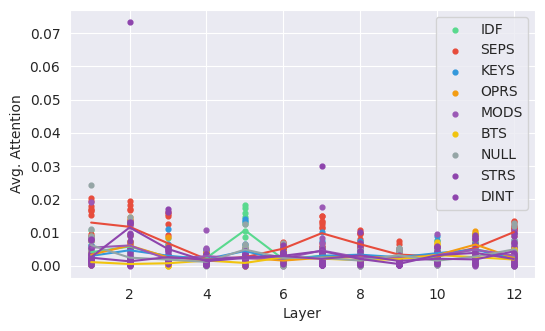

In [20]:
plt.figure(figsize=(6, 16))
ax = plt.subplot(4, 1, 1)
for key, color, label in [("identifier", GREEN, "IDF"),("separator", RED, "SEPS"), 
                          ("keyword", BLUE, "KEYS"), ("operator", ORANGE, "OPRS"), 
                          ("modifier", PURPLE, "MODS"), ("basictype", YELLOW, "BTS"), 
                          ("null", GRAY, "NULL"), ("string", BROWN, "STRS"), 
                          ("decimalinteger", CYAN, "DINT")]:
  add_line(key, ax, color, label, plot_avgs=True)

## Calculate average attention on CLS

In [21]:
block_size = 400
cls_data = np.zeros((12,12))

with torch.no_grad():
  for code_sample in tqdm(data[:10]):
    types_1, rewrote_code_1 = get_syntax_types_for_code(code_sample[3])
    types_2, rewrote_code_2 = get_syntax_types_for_code(code_sample[4])
    
    tokenized_ids_1 = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(rewrote_code_1))
    tokenized_ids_2 = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(rewrote_code_2))

    if len(tokenized_ids_2) > 400:
        tokenized_ids_2 = tokenized_ids_2[:399] + [tokenizer.sep_token_id]

    if len(tokenized_ids_1) > 400:
        tokenized_ids_1 = tokenized_ids_1[:399] + [tokenizer.sep_token_id]
    
    padding_length = block_size - len(tokenized_ids_1)
    tokenized_ids_1+=[tokenizer.pad_token_id]*padding_length
    padding_length = block_size - len(tokenized_ids_2)
    tokenized_ids_2+=[tokenizer.pad_token_id]*padding_length

    source_ids = tokenized_ids_1 + tokenized_ids_2
    labels = code_sample[2]
    source_ids = torch.tensor(source_ids).unsqueeze(0).to(device)
    labels = torch.tensor(labels).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(block_size,source_ids,labels)
    
    _attention = output[2].attentions # attention shape is layers, batchsize, heads, tokenLen, tokenLen
    
    for layer in range(12):
      for head in range(12):
        cls_data[layer][head] += _attention[layer][0][head][:, 0:1].mean().cpu().detach().numpy() 

CLS_atten = cls_data/len(data)

100%|██████████| 10/10 [00:00<00:00, 24.34it/s]


## Calculate average attention on SEP

In [22]:
sep_data = np.zeros((12,12))

with torch.no_grad():
  for code_sample in tqdm(data[:10]):
    types_1, rewrote_code_1 = get_syntax_types_for_code(code_sample[3])
    types_2, rewrote_code_2 = get_syntax_types_for_code(code_sample[4])
    
    tokenized_ids_1 = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(rewrote_code_1))
    tokenized_ids_2 = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(rewrote_code_2))

    if len(tokenized_ids_2) > 400:
        tokenized_ids_2 = tokenized_ids_2[:399] + [tokenizer.sep_token_id]

    if len(tokenized_ids_1) > 400:
        tokenized_ids_1 = tokenized_ids_1[:399] + [tokenizer.sep_token_id]
    
    padding_length = block_size - len(tokenized_ids_1)
    tokenized_ids_1+=[tokenizer.pad_token_id]*padding_length
    padding_length = block_size - len(tokenized_ids_2)
    tokenized_ids_2+=[tokenizer.pad_token_id]*padding_length

    source_ids = tokenized_ids_1 + tokenized_ids_2
    labels = code_sample[2]
    source_ids = torch.tensor(source_ids).unsqueeze(0).to(device)
    labels = torch.tensor(labels).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(block_size,source_ids,labels)
    
    _attention = output[2].attentions # attention shape is layers, batchsize, heads, tokenLen, tokenLen

    for layer in range(12):
      for head in range(12):
        for each_sep_index in torch.where(source_ids[0]==2)[0].cpu().detach().numpy():
          # print(each_sep_index)
          if each_sep_index <=400:
            sep_data[layer][head] += _attention[layer][0][head][:, each_sep_index].mean().cpu().detach().numpy() 

SEP_atten = sep_data/len(data)

100%|██████████| 10/10 [00:00<00:00, 22.34it/s]


In [23]:
avg_attns = {}
avg_attns = {'cls': CLS_atten, 'sep': SEP_atten}

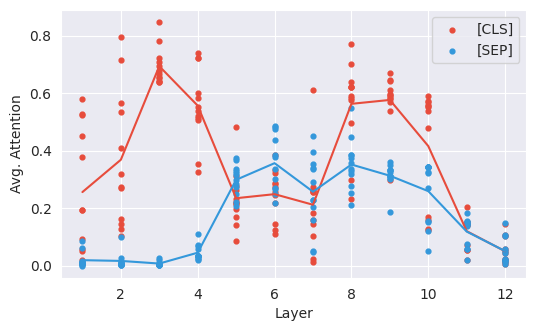

In [24]:
plt.figure(figsize=(6, 16))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("cls", RED, "[CLS]"),("sep", BLUE, "[SEP]")]:
  add_line(key, ax, color, label)

# Analyze misprediction and correct prediction diffs 

In [34]:
test_data_file = "../dataset/valid.txt"
block_size = 400
cpu_cont = 16
pool = multiprocessing.Pool(cpu_cont)
eval_dataset = load_and_cache_examples(tokenizer,
                                       test_data_file,
                                       block_size,
                                       sample_size=5000,
                                       evaluate=True,pool=pool)

Creating features from index file at %s  ../dataset/valid.txt


100%|██████████| 5000/5000 [00:05<00:00, 856.90it/s] 


In [35]:
len(eval_dataset)

5000

In [36]:
eval_sampler = SequentialSampler(eval_dataset)
eval_batch_size=32
eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size,num_workers=4,pin_memory=True)

In [37]:
eval_loss = 0.0
nb_eval_steps = 0
model.eval()
logits=[]  
y_trues=[]

for batch in eval_dataloader:
    inputs = batch[0].to(device)        
    labels=batch[1].to(device) 
    with torch.no_grad():
        lm_loss,logit,a = model(block_size,inputs,labels)
        eval_loss += lm_loss.mean().item()
        logits.append(logit.cpu().numpy())
        y_trues.append(labels.cpu().numpy())
    nb_eval_steps += 1
logits=np.concatenate(logits,0)
y_trues=np.concatenate(y_trues,0)

In [38]:
len(logits), len(y_trues)

(5000, 5000)

In [40]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

best_threshold=0
best_f1=0
for i in range(1,100):
    threshold=i/100
    y_preds=logits[:,1]>threshold
    recall=recall_score(y_trues, y_preds)
    precision=precision_score(y_trues, y_preds)
    f1=f1_score(y_trues, y_preds) 
    if f1>best_f1:
        best_f1=f1
        best_threshold=threshold
        
y_preds=logits[:,1]>best_threshold
recall=recall_score(y_trues, y_preds)
precision=precision_score(y_trues, y_preds)   
f1=f1_score(y_trues, y_preds)             
result = {
    "eval_recall": float(recall),
    "eval_precision": float(precision),
    "eval_f1": float(f1),
    "eval_threshold":best_threshold,
    
}

In [42]:
result

{'eval_recall': 0.9324522760646109,
 'eval_precision': 0.9365781710914455,
 'eval_f1': 0.9345106696100074,
 'eval_threshold': 0.98}

In [43]:
# get index for mispredcited and correctly predicted 
correct_precition_index = []
misprediction_index = []

for index, each in enumerate(y_preds):
  if each == y_trues[index]:
    correct_precition_index.append(index)
  else:
    misprediction_index.append(index)

In [44]:
len(correct_precition_index), len(misprediction_index)

(4911, 89)

In [46]:
correct_codes = []
mispredic_codes = []
for i in correct_precition_index:
    correct_codes.append(data[i])
    
for i in misprediction_index:
    mispredic_codes.append(data[i])

In [47]:
len(correct_codes), len(mispredic_codes)

(4911, 89)

In [ ]:
corrects = correct_codes[:185] + [187:1000]

In [48]:
syntax_attention_correct = getSyntaxAttentionScore(model,
                                                   corrects,
                                                   tokenizer,
                                                   syntax_list,
                                                   model_type='finetuned')

 22%|██▏       | 1102/4911 [25:38<2:07:39,  2.01s/it]

In [59]:
syntax_attention_mis = getSyntaxAttentionScore(model,
                                               mispredic_codes,
                                               tokenizer,
                                               syntax_list,
                                               model_type='finetuned')

100%|██████████| 22/22 [00:41<00:00,  1.90s/it]


In [64]:
syntax_attention_correct[0].keys()

dict_keys(['annotationfinetuned', 'basictypefinetuned', 'booleanfinetuned', 'decimalintegerfinetuned', 'identifierfinetuned', 'keywordfinetuned', 'modifierfinetuned', 'operatorfinetuned', 'separatorfinetuned', 'nullfinetuned', 'stringfinetuned', 'decimalfloatingpointfinetuned'])

In [65]:
correct_syntax = np.array(syntax_attention_correct)

## Read data from pickle file

In [3]:
# load pickled data
syntax_attention_correct = pickle.load(open("syntax_attention_correct.pkl", "rb"))

In [ ]:
syntax_attention_mis = pickle.load(open("syntax_attention_mis.pkl", "rb"))

In [73]:
avg_attns = {}
for syntaxType in syntax_list:
    temp = []
    for instance in syntax_attention_correct:
        a = np.array(instance[syntaxType +'finetuned'])
        if a.shape[0] != 0:
            a = a.squeeze(0)
            a = a.mean(axis=2)
            temp.append(a)
    if len(temp) != 0:
        temp = np.array(temp)
        temp = temp.reshape(temp.shape[1], temp.shape[2], temp.shape[0])
        avg_temp = temp.mean(axis=2)
        avg_attns[syntaxType+"_correct"] = avg_temp

In [76]:
avg_attns.keys()

dict_keys(['annotation_correct', 'basictype_correct', 'boolean_correct', 'decimalinteger_correct', 'identifier_correct', 'keyword_correct', 'modifier_correct', 'operator_correct', 'separator_correct', 'null_correct', 'string_correct', 'annotation_mispred', 'basictype_mispred', 'boolean_mispred', 'decimalinteger_mispred', 'identifier_mispred', 'keyword_mispred', 'modifier_mispred', 'operator_mispred', 'separator_mispred', 'null_mispred', 'string_mispred'])

In [75]:
for syntaxType in syntax_list:
    temp = []
    for instance in syntax_attention_mis:
        a = np.array(instance[syntaxType +'finetuned'])
        if a.shape[0] != 0:
            a = a.squeeze(0)
            a = a.mean(axis=2)
            temp.append(a)
    if len(temp) != 0:
        temp = np.array(temp)
        temp = temp.reshape(temp.shape[1], temp.shape[2], temp.shape[0])
        avg_temp = temp.mean(axis=2)
        avg_attns[syntaxType+"_mispred"] = avg_temp

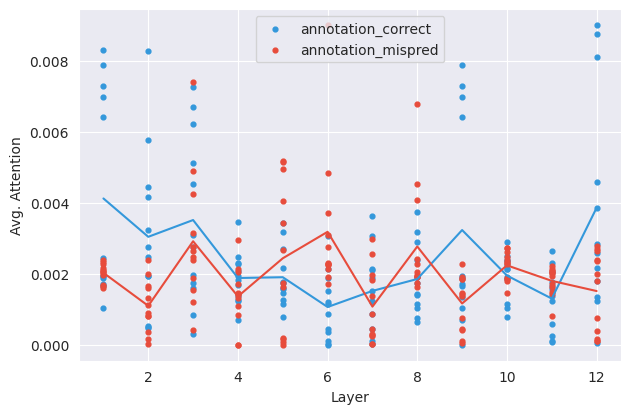

In [77]:
plt.figure(figsize=(7, 21))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("annotation_correct", BLUE, "annotation_correct"),
                          ("annotation_mispred", RED, "annotation_mispred")]:
  add_line(key, ax, color, label)

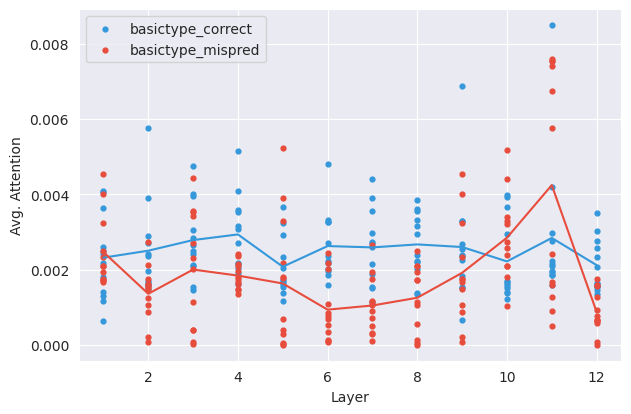

In [78]:
plt.figure(figsize=(7, 21))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("basictype_correct", BLUE, "basictype_correct"),
                          ("basictype_mispred", RED, "basictype_mispred")]:
  add_line(key, ax, color, label)

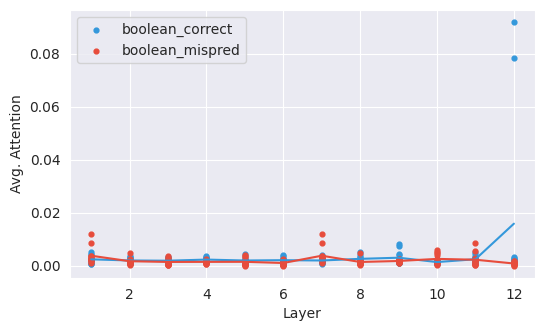

In [83]:
plt.figure(figsize=(6, 16))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("boolean_correct", BLUE, "boolean_correct"),
                          ("boolean_mispred", RED, "boolean_mispred")]:
  add_line(key, ax, color, label)

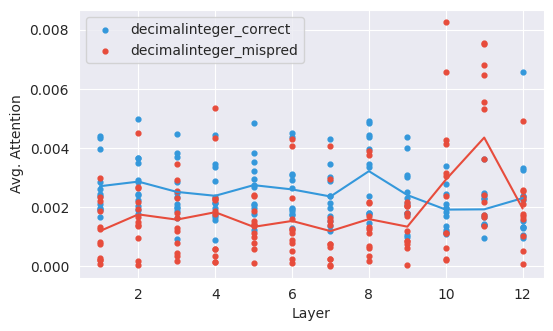

In [84]:
plt.figure(figsize=(6, 16))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("decimalinteger_correct", BLUE, "decimalinteger_correct"),
                          ("decimalinteger_mispred", RED, "decimalinteger_mispred")]:
  add_line(key, ax, color, label)

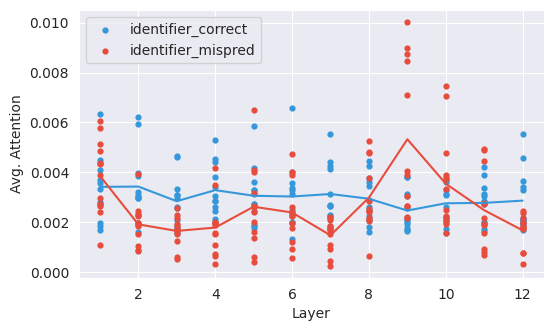

In [85]:
plt.figure(figsize=(6, 16))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("identifier_correct", BLUE, "identifier_correct"),
                          ("identifier_mispred", RED, "identifier_mispred")]:
  add_line(key, ax, color, label)

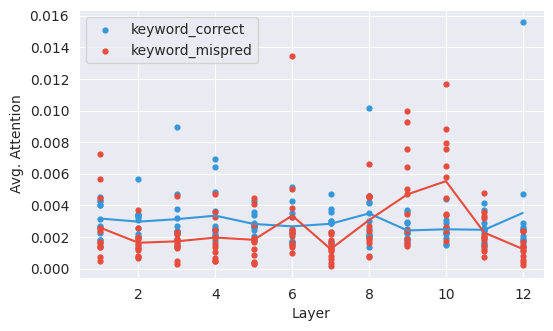

In [86]:
plt.figure(figsize=(6, 16))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("keyword_correct", BLUE, "keyword_correct"),
                          ("keyword_mispred", RED, "keyword_mispred")]:
  add_line(key, ax, color, label)

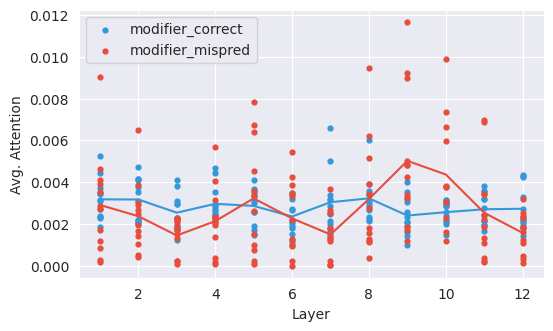

In [87]:
plt.figure(figsize=(6, 16))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("modifier_correct", BLUE, "modifier_correct"),
                          ("modifier_mispred", RED, "modifier_mispred")]:
  add_line(key, ax, color, label)

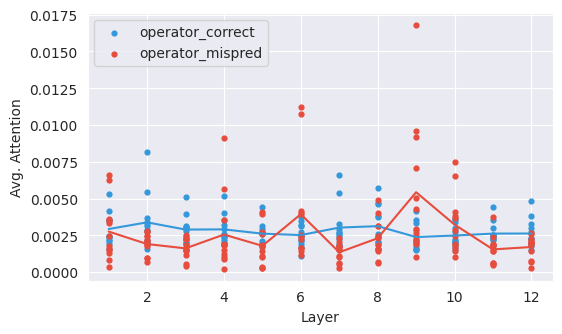

In [88]:
plt.figure(figsize=(6, 16))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("operator_correct", BLUE, "operator_correct"),
                          ("operator_mispred", RED, "operator_mispred")]:
  add_line(key, ax, color, label)

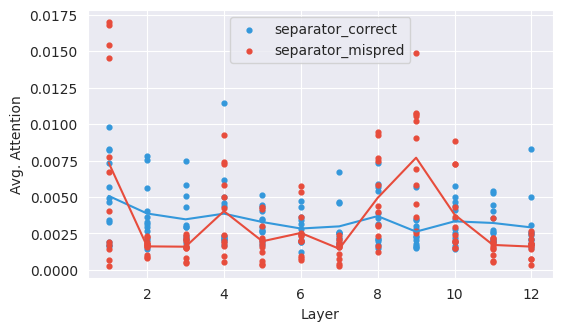

In [89]:
plt.figure(figsize=(6, 16))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("separator_correct", BLUE, "separator_correct"),
                          ("separator_mispred", RED, "separator_mispred")]:
  add_line(key, ax, color, label)

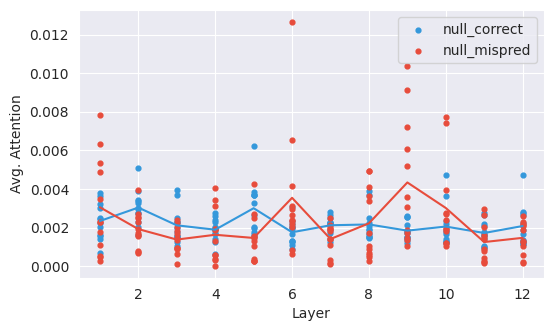

In [90]:
plt.figure(figsize=(6, 16))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("null_correct", BLUE, "null_correct"),
                          ("null_mispred", RED, "null_mispred")]:
  add_line(key, ax, color, label)

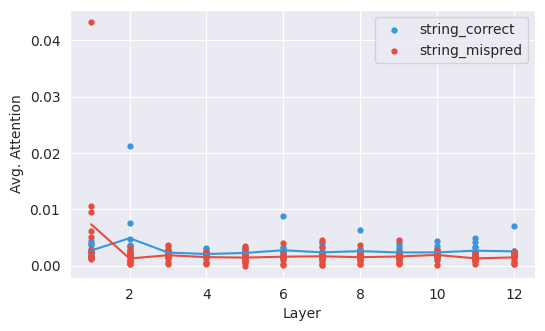

In [91]:
plt.figure(figsize=(6, 16))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("string_correct", BLUE, "string_correct"),
                          ("string_mispred", RED, "string_mispred")]:
  add_line(key, ax, color, label)